In [7]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")
ExpZ2Mat = pd.read_csv("dat/z2.all.genes.str.mat.csv", index_col=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_2stage.shape
#Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-2]
#Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage[
#    "pDenovoWEST_Meta"]<=1e-2]
Spark_Meta_ExomeWide.shape

(159, 67)

In [32]:
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights2(Spark_Meta_ExomeWide, 
          allen_mouse_genes = allen_mouse_genes, 
          out = "dat/bias2/meta.ew.gene.weights.csv")
len(Agg_gene2MutN)

147

In [33]:
ASD_EW_Z2_NoNeg = AvgSTRZ_Weighted(ExpZ2Mat, Agg_gene2MutN, Method = 1, NonNeg=True, 
                                              csv_fil = "dat/bias2/ASD.EW.pLI.z2.NoNeg.csv")
RD_Agg_avgZ_RD = RegionDistributions(ASD_EW_Z2_NoNeg.set_index("STR"), show=True)

Isocortex 	 21 	 Orbital_area_lateral_part; Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Primary_motor_area; Frontal_pole_cerebral_cortex; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Visceral_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Gustatory_areas; Orbital_area_medial_part; Anterolateral_visual_area; Primary_somatosensory_area_barrel_field; Supplemental_somatosensory_area; Agranular_insular_area_posterior_part
Thalamus 	 6 	 Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus; Central_lateral_nucleus_of_the_thalamus; Rhomboid_nucleus
Hippocampus 	 7 	 Dentate_gyrus; Field_CA1; Field_CA2; Subiculum_ventral_part; Field_CA3; Subiculum_dorsal_part; Parasubiculum
Striatum 	 2 	 Nucleus_accumbens; Lateral_septal_nucleus_ventral_part
Pons

In [34]:
Circuit_STRs = ASD_EW_Z2_NoNeg["STR"].values

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,  3.,  4.,  9., 19.,
        12., 23., 21., 22., 14.,  7.,  6.]),
 array([0.2066363 , 0.22018362, 0.23373094, 0.24727826, 0.26082558,
        0.2743729 , 0.28792022, 0.30146754, 0.31501486, 0.32856218,
        0.3421095 , 0.35565682, 0.36920414, 0.38275146, 0.39629878,
        0.4098461 , 0.42339342, 0.43694074, 0.45048806, 0.46403538,
        0.4775827 ]),
 <BarContainer object of 20 artists>)

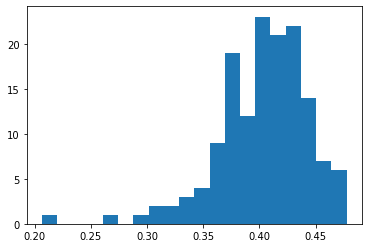

In [45]:
neg_genes = []
biases = []
for entrez in Agg_gene2MutN.keys():
    g_biases = []
    for STR in Circuit_STRs:
        b = ExpZ2Mat.loc[entrez, STR]
        g_biases.append(b)
    g_avgBias = np.mean([max(0,x) for x in g_biases])
    #g_avgBias = np.mean( g_biases)
    biases.append(g_avgBias)
    if g_avgBias <0.35:
        neg_genes.append(entrez)

plt.hist(biases, bins=20)

In [46]:
len(neg_genes)

11

In [47]:
neg_gene_dict = {}
for k,v in Agg_gene2MutN.items():
    if k in neg_genes:
        neg_gene_dict[k] = v

In [48]:
ASD_Neg_Spec = AvgSTRZ_Weighted(ExpZ2Mat, neg_gene_dict,Method = 1, NonNeg=True,
                                              csv_fil = "dat/bias2/Neg.Spec.bias.csv")
RD_Agg_avgZ_RD = RegionDistributions(ASD_Neg_Spec.set_index("STR"), show=True)

Isocortex 	 1 	 Frontal_pole_cerebral_cortex
Thalamus 	 21 	 Parataenial_nucleus; Lateral_posterior_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Paraventricular_nucleus_of_the_thalamus; Nucleus_of_reuniens; Rhomboid_nucleus; Central_medial_nucleus_of_the_thalamus; Anteromedial_nucleus_dorsal_part; Anteroventral_nucleus_of_thalamus; Intermediodorsal_nucleus_of_the_thalamus; Parafascicular_nucleus; Subparafascicular_area; Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part; Anterodorsal_nucleus; Submedial_nucleus_of_the_thalamus; Peripeduncular_nucleus; Medial_geniculate_complex_dorsal_part; Ventral_medial_nucleus_of_the_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Lateral_dorsal_nucleus_of_thalamus
Hippocampus 	 1 	 Dentate_gyrus
Striatum 	 2 	 Fundus_of_striatum; Lateral_septal_nucleus_ventral_part
Pons 	 1 	 Superior_central_nucleus_raphe
Hypothalamus 	 8 	 Medial_preoptic_nucleus; Medial_preoptic_area; Par